![logo](./figures/LogoLine_horizon_C3S.png)

# Geographic Map

This Jupyter Notebook reproduces the Geographic Map product (see figure bellow) from the C3S Atlas.

A particular choice of dataset, variable, quantity & scenario and season determines a final product. The bellow figure represents as example the “CMIP6 - Mean of daily accumulated precipitation (mm/day) Change (%) - Warming 2°C SSP5-8.5 (rel. to 1981-2010) - Annual”) which is displayed globally. The map shows the ensemble mean values or changes (absolute or relative –relative changes of the ensemble mean–, depending on the variable). It can be visualized in the C3S Atlas using the following [Permalink](https://atlas.climate.copernicus.eu/atlas/MMYz6fCy)

To limit the time spent, the spatial map product is calculated for a specific region (Spain)

![spatial_map](./figures/spatial_map.png)

**Uncertainty**: Visualizing the robustness/uncertainty together with future climate change signals is standard practice to convey comprehensive climate change projections. This information is typically overlaid on the climate change signal using hatching (diagonal lines or crosses obscuring areas with uncertain signals).The advanced method for representing the ensemble robustness of the climate change signal is the approach proposed in AR6. It consists of three categories: 1) robust signal, 2) conflicting signals (crosses overlying the signals), and 3) no change or no robust signal (diagonal lines overlaid on the signal). The first two categories indicate significant changes, i.e. areas where the (20-year mean) climate change model signal likely emerges (individually in >=66% of the models) from the internal variability of 20-year mean values; these changes are defined as robust if at least 80% of the models agree on the sign of change, and as conflicting if less than 80% of the models agree on the sign of change. The third category indicates areas of low change values and/or low significance, where less than 66% of the models exhibit emergent signals. The level of Internal variability (or emergence threshold) was computed as 1.645*sqrt(2/20)*sigma, where 1.645 corresponds to a 90% confidence level and sigma represents the inter-annual standard deviation computed from the linearly detrended baseline period 1971-2005 ([IPCC AR6-WGI Atlas](https://www.cambridge.org/core/books/climate-change-2021-the-physical-science-basis/atlas/24E1C016DBBE4725BDFBC343695DE7DB); [Cross-Chapter Box Atlas.1](https://www.cambridge.org/core/books/climate-change-2021-the-physical-science-basis/atlas/24E1C016DBBE4725BDFBC343695DE7DB))

Note that robustness results are computed at a gridbox level and are not representative of regionally aggregated results over larger regions (less influenced by local variability).

### Load Python packages and clone and install the c3s-atlas GitHub repository from the ecmwf-projects

Clone (`git clone`) the [c3s-atlas](https://github.com/ecmwf-projects/c3s-atlas) repository and install them (`pip install -e .`).

Further details on how to clone and install the repository are available in the [requirements section](https://github.com/ecmwf-projects/c3s-atlas?tab=readme-ov-file#requirements)

In [3]:
import xarray as xr
import glob
from datetime import date
import numpy as np
from pathlib import Path
import cdsapi
import os

from c3s_atlas.utils import (
    season_get_name,
    extract_zip_and_delete,
)
from c3s_atlas.customized_regions import (
    Mask
)
from c3s_atlas.analysis import (
    mean_values_map,
    categories_robustness,
    significance_trends,
)
from c3s_atlas.products import (
    hatched_map_plot,
)
from c3s_atlas.GWLs import (
    load_GWLs,
    select_member_GWLs,
    get_mean_data_by_months
)

### Download climate data with the CDS API
To reduce data size and download time, a geographical subset focusing on a specific area within the European region (Spain) is selected.

- Catalogue: [Gridded dataset underpinning the Copernicus Interactive Climate Atlas](https://cds.climate.copernicus.eu/datasets/multi-origin-c3s-atlas?tab=overview)

In [4]:
cdsapi_url= "https://cds.climate.copernicus.eu/api"
cdsapi_key= ""

In [ ]:
c = cdsapi.Client(url=cdsapi_url, key=cdsapi_key)

> ⚠️ **Warning: Exposed API Credentials**
>
> For security reasons, it is not recommended to hardcode your Copernicus Climate Data Store (CDS) API credentials — such as `cdsapi_url` and `cdsapi_key` — directly in notebooks.
>
> Instead, it is best to store them securely in a `.cdsapirc` file located in your home directory.
>
> 📄 More info: [CDS API - How to use the API](https://cds.climate.copernicus.eu/how-to-api)

In [6]:
project = "CMIP6"
scenario = "ssp370"
var = 'r'
# directory to download the files
dest = Path('./data/CMIP6')
os.makedirs(dest, exist_ok=True)

##### Download historical scenario

In [ ]:
filename = 'r_CMIP6_historical_mon_185001-201412.zip'
dataset = "multi-origin-c3s-atlas"
request = {
    "origin": "cmip6",
    "experiment": "historical",
    "period": "1850-2014",
    "variable": "monthly_precipitation",
    "bias_adjustment": "no_bias_adjustment",
    'area': [44.5, -9.5, 35.5, 3.5]
}

c.retrieve(dataset, request).download(dest / filename)
extract_zip_and_delete(dest / filename) 

##### Download SSP scenario

In [ ]:
filename = 'r_CMIP6_ssp370_mon_201501-210012.zip'
dataset = "multi-origin-c3s-atlas"
request = {
    "origin": "cmip6",
    "experiment": "ssp3_7_0",
    "period": "2015-2100",
    "variable": "monthly_precipitation",
    "bias_adjustment": "no_bias_adjustment",
    'area': [44.5, -9.5, 35.5, 3.5]
}

c.retrieve(dataset, request).download(dest / filename)
extract_zip_and_delete(dest / filename) 

#### Concatenate historical and SSP scenarios
Note that the historical and SSP scenarios may have a different number of members. Here, common members from the historical and SSP scenarios are concatenated into a single [xarray.Dataset](https://docs.xarray.dev/en/stable/generated/xarray.Dataset.html) to facilitate their use going forward.

In [10]:
ds_hist = xr.open_dataset(dest / "r_CMIP6_historical_mon_185001-201412.nc")
ds_sce = xr.open_dataset(dest / "r_CMIP6_ssp370_mon_201501-210012.nc")
mem_inters = np.intersect1d(ds_hist.member_id.values, ds_sce.member_id.values)
ds_hist = ds_hist.isel(member = np.isin(ds_hist.member_id.values, mem_inters))
ds_sce = ds_sce.isel(member = np.isin(ds_sce.member_id.values, mem_inters))
ds = xr.concat([ds_hist, ds_sce], dim = 'time')

##### Define season
###### We select month 8 (August) as an example to viusalize the results

In [11]:
season = [8] # Months

In [12]:
attrs = {
    "project" : project,
    "scenario": scenario,
    "variable": var,
    "season": season,
    "season_name" : season_get_name(season),
    "actual_year": date.today().year,
    "unit" : ds[var].units    
}

## Climatology

### Analysis
The **mean_values_map** function calculates the mean value over the time dimension for a specific period.

In [13]:
mode = 'climatology'
period = slice('2081', '2100')

In [14]:
mean_map_ds = mean_values_map(ds, var, project, mode = mode, 
                              season = season, period = period)

### Plot

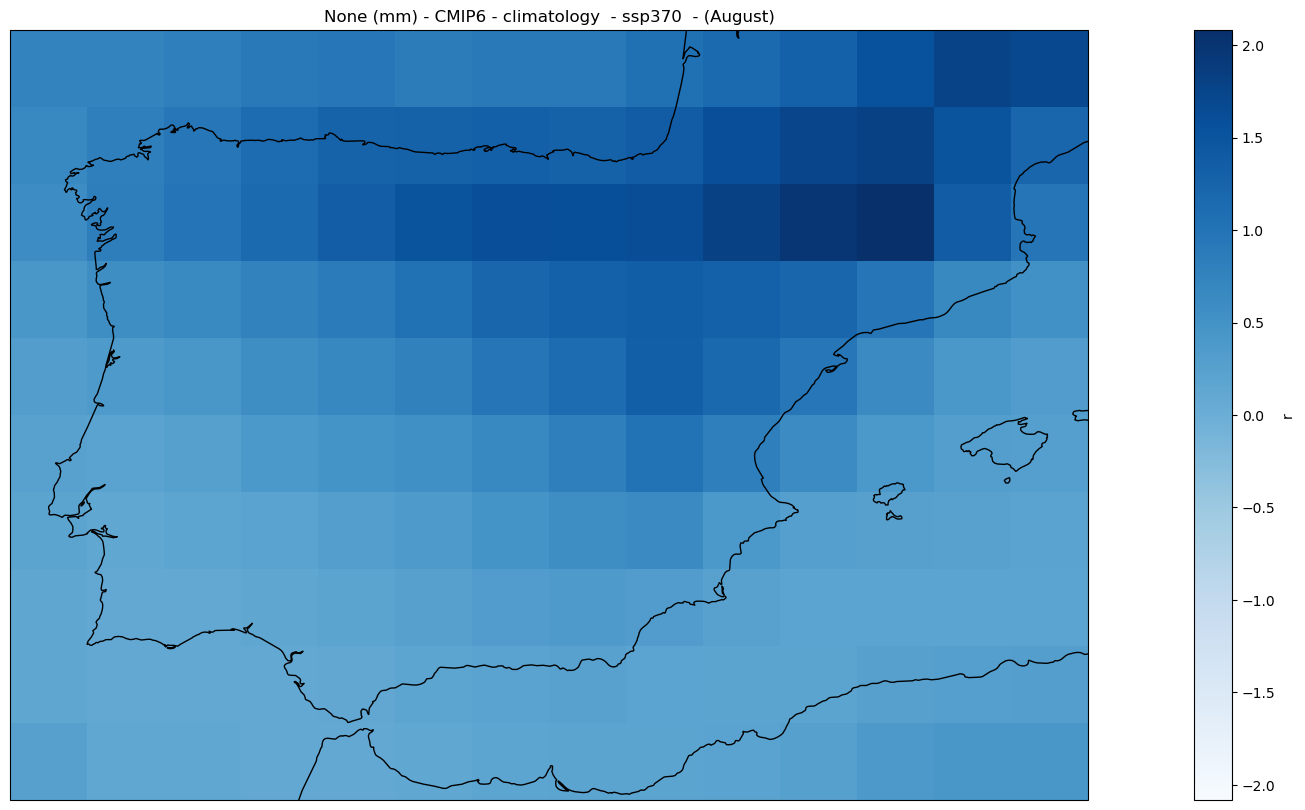

In [15]:
fig = hatched_map_plot(mean_map_ds, var, attrs, mode = 'climatology', cmap = 'Blues')

## Absolute change

### Analysis
The **categories_robustness** function calculate the category of robustness of the climate signal for each gridbox, using the same approaches as those in the IPCC WGI AR6 report ([Cross-Chapter Box Atlas.1](https://www.cambridge.org/core/books/climate-change-2021-the-physical-science-basis/atlas/24E1C016DBBE4725BDFBC343695DE7DB)).

In [16]:
mode = 'change'
diff = 'abs'
period = slice('2081', '2100')
baseline_period = slice('1981', '2010')

In [17]:
mean_map_ds = mean_values_map(ds, var, project, mode = mode, diff = diff, 
                              season = season, period = period,
                              baseline_period = baseline_period)

In [18]:
# calculate robusteness 
# Note that this product is time-cosuming and can take several minutes
categories_ds = categories_robustness(ds, var, season = season, 
                                      period = period,
                                      baseline_period = baseline_period)

### Plot

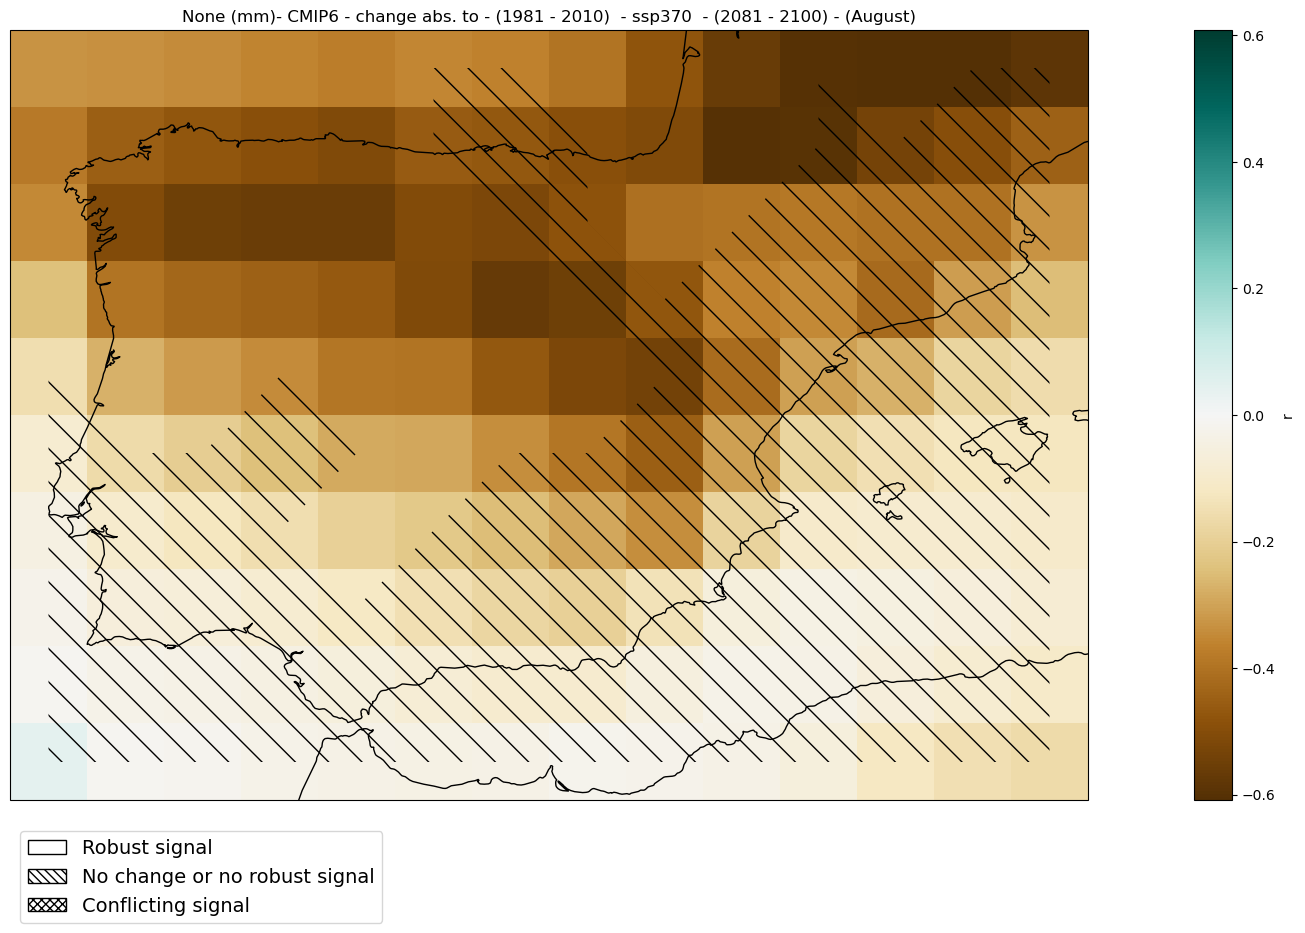

In [19]:
fig = hatched_map_plot(mean_map_ds, var, attrs, 
                       mode = mode, diff = diff, 
                       categories = categories_ds[0], 
                       period = period, baseline_period = baseline_period,
                       cmap = 'BrBG')

## Relative Change

In [20]:
mode = 'change'
diff = 'rel'
period=slice('2081', '2100')
baseline_period=slice('1981', '2010')

In [21]:
mean_map_ds = mean_values_map(ds, var, project, mode = mode, diff = diff, 
                              season = season, period = period,
                              baseline_period = baseline_period)

In [22]:
# The robustness analysis is indifferent to the mode (abs/rel)
#categories_ds = categories_robustness(ds, var, months = season, 
#                                      period = period,
#                                      baseline_period = baseline_period)

### Plot

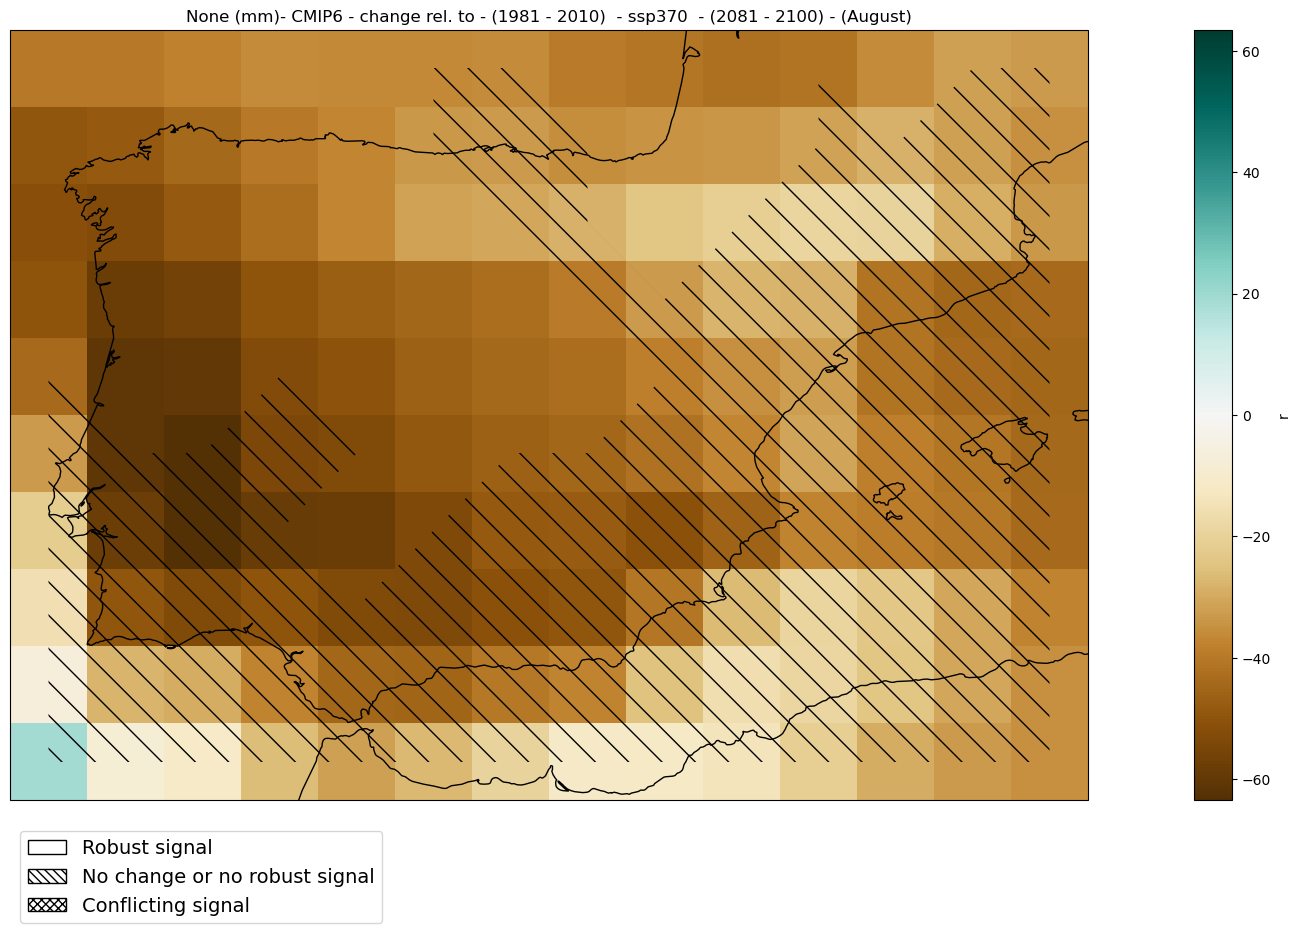

In [23]:
fig = hatched_map_plot(mean_map_ds, var, attrs, 
                       mode = mode, diff = diff, 
                       categories = categories_ds[0], 
                       period = period, baseline_period = baseline_period,
                       cmap = 'BrBG')

## Global Warming Levels
Here, the spatial map is displayed for a specific Global Warming Level (GWL). To achieve this, the 20-year period in which each ensemble member reaches the chosen GWL is selected. The spatial map is then shown, representing either climatology or change for this specific period and region (Spain in this notebook).

These periods are calculated in the notebook [GWLs.ipynb](GWLs.ipynb) for CMIP5 and CMIP6. For CORDEX, the results from the driving CMIP5 models are used.

In [24]:
GWL = '4'

In [25]:
#Load the data and get the intersection of the members
GWLs_ds = load_GWLs(project)
GWLs_members_with_period = select_member_GWLs(ds, GWLs_ds, project, scenario, GWL)
[GWL_data, filtered_GWLs_ds]=get_mean_data_by_months(ds, GWLs_members_with_period)

### Analysis

In [26]:
mode = 'change'
diff = 'abs'
baseline_period = slice('1981', '2010')

In [27]:
mean_map_ds = mean_values_map(filtered_GWLs_ds, var, project, mode = mode,  
                            diff = diff, season = season, 
                            baseline_period = baseline_period, GWLs_ds = GWL_data)

In [28]:
categories_ds = categories_robustness(filtered_GWLs_ds, var, season = season, 
                                       baseline_period =  baseline_period, 
                                       GWLs_ds = GWL_data)

### Plot

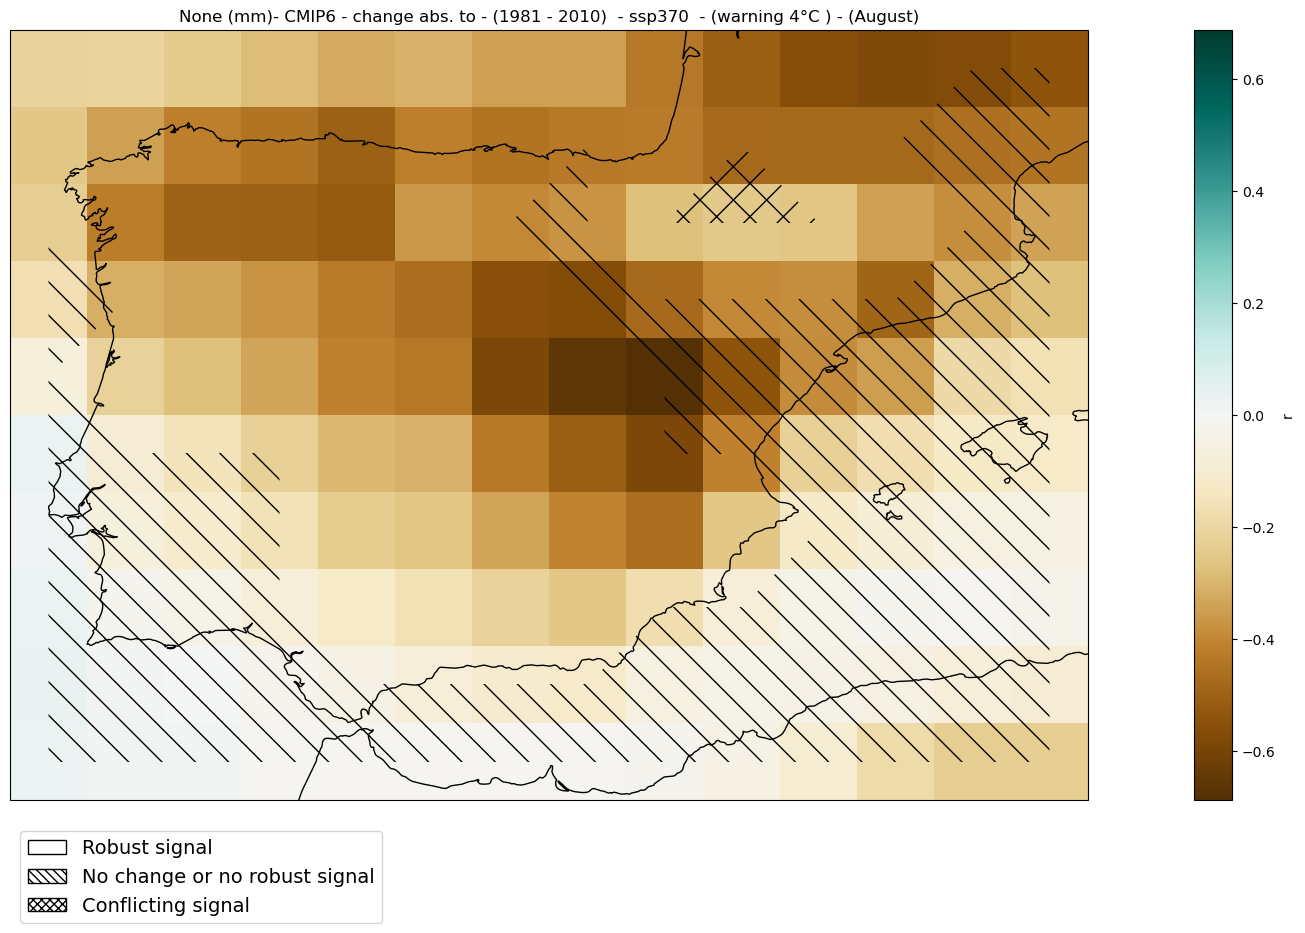

In [29]:
hatched_map_plot(mean_map_ds, var, attrs, mode = mode, diff = diff, 
                 categories = categories_ds[0], 
                 baseline_period = baseline_period, GWLs = GWL,
                 cmap = 'BrBG')

## Trends
Trend analysis is only available for observations and reanalysis. This type of analysis is not appropriate for projections since climate change does not necessarily scale linearly with global warming.

#### Download data from the "Gridded dataset underpinning the Copernicus Interactive Climate Atlas"

In [30]:
project = "ERA5"
var = 't'
season = [8]
trend_period = period = slice('1991','2020')

In [31]:
dest = Path('./data/ERA5')
os.makedirs(dest, exist_ok=True)

In [ ]:
filename = 't_ERA5_mon_194001-202212.zip'

dataset = "multi-origin-c3s-atlas"
request = {
    "origin": "era5",
    "domain": "global",
    "period": "1940-2024",
    "variable": "monthly_temperature",
    "bias_adjustment": "no_bias_adjustment",
    'area': [44.5, -9.5, 35.5, 3.5]
}

c.retrieve(dataset, request).download(dest / filename)
extract_zip_and_delete(dest / filename) 

In [33]:
ds = xr.open_dataset(dest / "t_ERA5_mon_194001-202212.nc")

In [34]:
attrs = {
    "project" : project,
    "variable": var,
    "season": season,
    "season_name" : season_get_name(season),
    "actual_year": date.today().year,
    "unit" : ds[var].units    
}

### Analysis
The **significance_trends** function calculates and returns p-values for linear regression trends for each latitude-longitude point. Robustness is defined using the significance of the linear trends as obtained from standard hypothesis testing (and obscuring regions with non-significant trends using "x"). 

A p-value indicates the level of significance of the trend:
- A small p-value (usually less than 0.05) means it’s very unlikely to be random — so we can trust the trend is significant.
- A large p-value means the trend might just be noise or coincidence, so we don’t consider it reliable.

In [35]:
ds = significance_trends(ds, var, season, trend_period = trend_period)

### Plot

In [36]:
mode = 'trends'
pvalue = 0.05 # level of significance

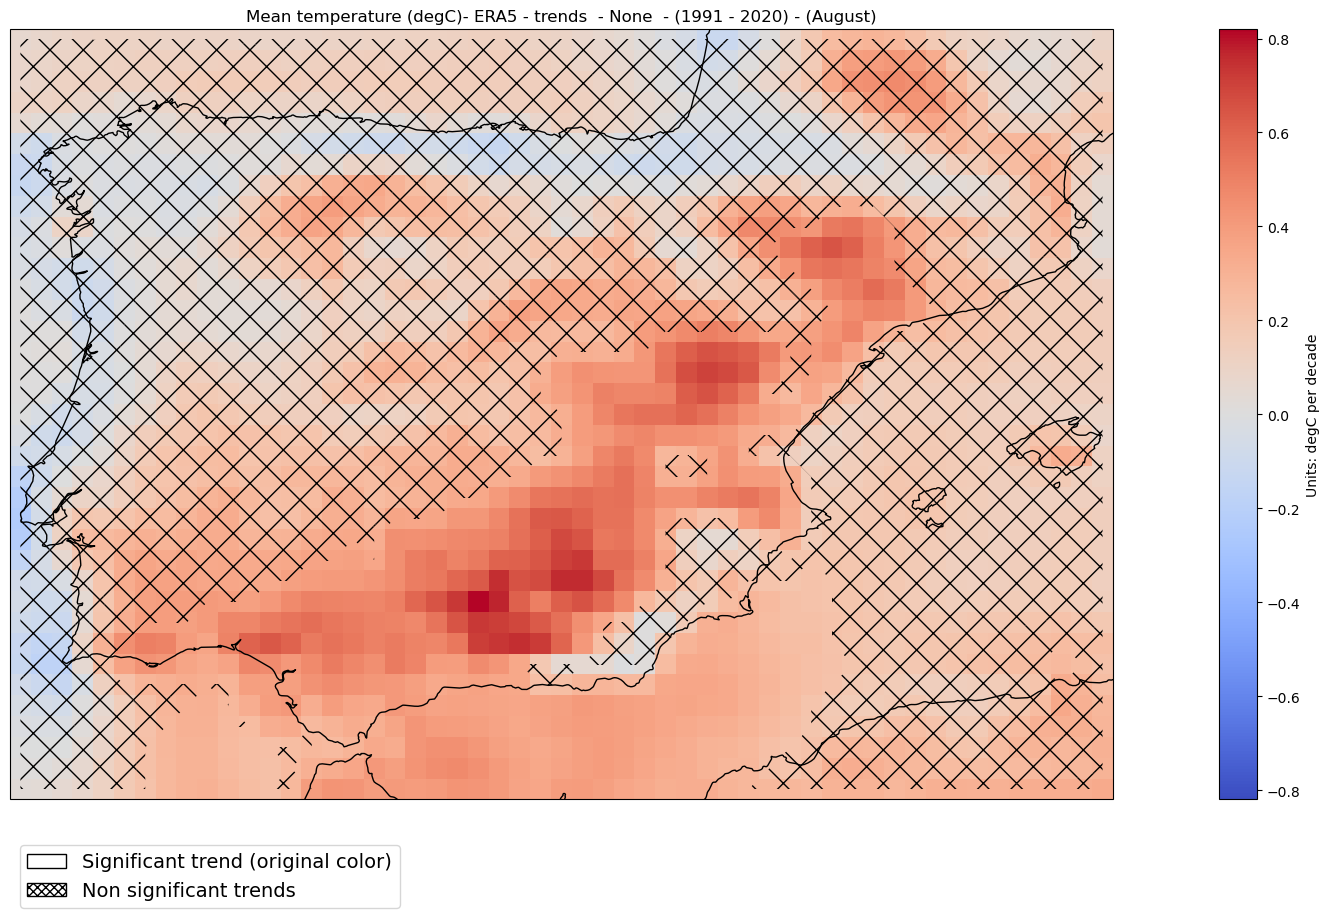

In [37]:
hatched_map_plot(ds, var, attrs, mode = mode, 
                 period = period, pvalue = 0.05, cmap = 'coolwarm')